In [3]:
library(tidyverse)
library(dplyr)
library(readr)
library(data.table)
library(purrr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




## ISD Dataset analysis

This notebook attempts to answer the following questions, using Chris' list of toxic terms:
- What percentage of tweets at each user of interest is toxic?
- Is there a gender disparity between rates of toxicity? IE, does one gender experience a greater percentage of toxic tweets?
- What percentage of tweets from each category of users of interest are toxic?

Note that due to the size of the dataset some cells might take a painfully long time to run. I tried my best to cut down on execution time, but this is the best I could do. 

I exclude retweets from this analysis due to them not adding any new textual info. It would be nice, however, to perhaps analyze what kinds of tweets are being retweeted. 

In [4]:
UBC_ISD <- fread("UBC-ISD.csv", encoding = "UTF-8")

In [5]:
UBC_ISD_text <- UBC_ISD |>
select("twitter.tweet/text")|>
rename(text="twitter.tweet/text")|>
mutate_all(na_if,"")|>
drop_na()|>
distinct() #removes retweets


In [6]:
terms <- c('fuck', 'dirty', 'stupid', 'idiot', 'asshole', 'bastard', 'nasty', 'whore', 'slut', 'skank', 'cunt', 'bitch', 'motherfucker', 'go to hell', 'wimp', 'coward', 'moron', 'traitor', 'shut up', 'shut the fuck up', 'stfu', 'piece of shit', 'ignorant', 'clown', 'ccpvirus', 'chinese coronavirus', 'chinavirus', 'china virus', 'fuckchina', 'nukechina', 'bombchina', 'deathtochina', 'chinesevirus', 'fake lab wuhan', 'china weapon', 'china bioweapon', 'zionazi', 'Soros virus', 'blood libel', 'nwovirus', 'new world order', 'sacrifice children', 'jew world order', 'liar', 'yellow star', 'israel virus', 'israelvirus', 'rothschild covid', 'kalergi plan', 'jail', 'locked up', 'evil.', 'is evil', 'so evil', 'pure evil', 'an evil', 'evil wom', 'evil man', 'evil witch', 'is evil', 'are evil', 'that evil', 'very evil', 'tyrant', 'tyranny', 'dictator', 'tv doctor', 'twitter doctor', 'murder', 'murderer', 'eugenic', 'satan', 'Nazi', 'non-human', 'sterile', 'slave', 'crooked', 'corrupt', 'shill', 'liar', 'lying', 'killer', 'fraud', 'big pharma', 'pharma puppet', 'Nuremberg', 'crimes against humanity', 'genocide', 'child abuse', 'covid hoax', 'covid fake', 'virus hoax', 'gates virus', 'bioweapon', 'secret elite', 'depopulation', 'save our children', 'scamdemic', 'plandemic')
terms <- paste0(" ", terms)
pattern <- paste(terms, collapse = "|")

In [13]:

users <- c("adriandix", "AlikaMD", "AmyGreerKalisz", "angie_rasmussen", "AnnaBlakney", 
           "AntibioticDoc", "asapscience", "ASPphysician", "atRachelGilmore", "binhanv", 
           "BirinderNarang", "blackdocscanada", "BogochIsaac", "bornk", "carlyweeks", 
           "CaulfieldTim", "CDCofBC", "cdube_sante", "cfpcceo", "ChiefSciCan", "cmcovidtf", 
           "CMOH_Alberta", "CMOH_NL", "conquercovid19", "COVID_19_Canada", "COVIDSciOntario", 
           "CPHO_Canada", "ctouzin", "CTV_AvisFavaro", "DeNovo_Fatima", "deonandan", "drfisman", 
           "Dr_ChrisSimpson", "drgigiosler", "DrKaliBarrett", "drmwarner", "drsusanshaw", 
           "DrVivianS", "egpayne", "epdevilla", "ErnieHudsonPEI", "everetthindley", "First10EM", 
           "GermHunterMD", "glenpyle", "heysciencesam", "hgagneTVA", "IDEpiPhD", "imgrund", 
           "iPreetBrar", "IrfanDhalla", "j_mcelroy", "jasonfherring", "jfrketich", "jkwan_md", 
           "Johnrockdoc", "JuliaWongCBC", "juliegreenMLA", "Justin_Ling", "jyangstar", "KashPrime", 
           "KatharineSmart", "Kevin_Parent", "KindrachuckJason", "KrishanaSankar", "kwadwo777", 
           "LaurenPelley", "LisaBarrettID", "McGillOSS", "MerrimanPaul", "MichaelSchwandt", 
           "MLAStefanson", "moirawyton", "moriartylabs", "MPaiMD", "NaheedD", "NathanStall", 
           "NightShiftMD", "NoLore", "OttawaHealth", "paimadhu", "PattyHajdu", "picardonhealth", 
           "RicharLisa", "roussin_brent", "sabaeitizaz", "sabiVM", "SammyG_MD", "sarperotto", 
           "SciChefCan", "sciencemonkeyca", "ScienceUpFirst", "sdbaral", "shandro", "SharkawyMD", 
           "shazmamithani", "ShephardDorothy", "srinmurthy99", "SteiniBrown", "theresaboyle", 
           "thisisourshotca", "TorontoIDDOC", "UbakaOgbogu", "VaxHuntersCan", "VeraEtches", 
           "VikCBC", "wickdchiq", "zachchurchhill", "zchangla", "DrKathleenRoss1")

# Creating an empty list to store the dataframes
negative_proportions <- list()
total_entries <- nrow(UBC_ISD_text)
#filtering tweets for each user and adding a column for hate speech: value of 1 if row contains hate speech, 0 if not.
filter_tweets <- function(user) {

  filtered_data <- UBC_ISD_text |>
    filter(grepl(user, text, ignore.case = TRUE)) |>
    mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))

  negative_entries <- nrow(filtered_data |> filter(negative == 1))

  percent_negative <- (negative_entries / total_entries) * 100

  return(percent_negative)
}

# Looping through each user and storing the negative percentage in the list
for (user in users) {
  negative_proportions[[user]] <- filter_tweets(user)
}


To view each individual's percentage, run `negative_proprtions$username`. Example:

In [11]:
negative_proportions$adriandix

[1] 0.1344195

In [12]:
user_csv <- data.frame(
  user = c("adriandix", "AlikaMD", "AmyGreerKalisz", "angie_rasmussen", "AnnaBlakney", 
           "AntibioticDoc", "asapscience", "ASPphysician", "atRachelGilmore", "binhanv", 
           "BirinderNarang", "blackdocscanada", "BogochIsaac", "bornk", "carlyweeks", 
           "CaulfieldTim", "CDCofBC", "cdube_sante", "cfpcceo", "ChiefSciCan", "cmcovidtf", 
           "CMOH_Alberta", "CMOH_NL", "conquercovid19", "COVID_19_Canada", "COVIDSciOntario", 
           "CPHO_Canada", "ctouzin", "CTV_AvisFavaro", "DeNovo_Fatima", "deonandan", "drfisman", 
           "Dr_ChrisSimpson", "drgigiosler", "DrKaliBarrett", "drmwarner", "drsusanshaw", 
           "DrVivianS", "egpayne", "epdevilla", "ErnieHudsonPEI", "everetthindley", "First10EM", 
           "GermHunterMD", "glenpyle", "heysciencesam", "hgagneTVA", "IDEpiPhD", "imgrund", 
           "iPreetBrar", "IrfanDhalla", "j_mcelroy", "jasonfherring", "jfrketich", "jkwan_md", 
           "Johnrockdoc", "JuliaWongCBC", "juliegreenMLA", "Justin_Ling", "jyangstar", "KashPrime", 
           "KatharineSmart", "Kevin_Parent", "KindrachuckJason", "KrishanaSankar", "kwadwo777", 
           "LaurenPelley", "LisaBarrettID", "McGillOSS", "MerrimanPaul", "MichaelSchwandt", 
           "MLAStefanson", "moirawyton", "moriartylabs", "MPaiMD", "NaheedD", "NathanStall", 
           "NightShiftMD", "NoLore", "OttawaHealth", "paimadhu", "PattyHajdu", "picardonhealth", 
           "RicharLisa", "roussin_brent", "sabaeitizaz", "sabiVM", "SammyG_MD", "sarperotto", 
           "SciChefCan", "sciencemonkeyca", "ScienceUpFirst", "sdbaral", "shandro", "SharkawyMD", 
           "shazmamithani", "ShephardDorothy", "srinmurthy99", "SteiniBrown", "theresaboyle", 
           "thisisourshotca", "TorontoIDDOC", "UbakaOgbogu", "VaxHuntersCan", "VeraEtches", 
           "VikCBC", "wickdchiq", "zachchurchhill", "zchangla", "DrKathleenRoss1"),
  value = c(negative_proportions$adriandix, negative_proportions$AlikaMD, negative_proportions$AmyGreerKalisz, 
            negative_proportions$angie_rasmussen, negative_proportions$AnnaBlakney, negative_proportions$AntibioticDoc, 
            negative_proportions$asapscience, negative_proportions$ASPphysician, negative_proportions$atRachelGilmore, 
            negative_proportions$binhanv, negative_proportions$BirinderNarang, negative_proportions$blackdocscanada, 
            negative_proportions$BogochIsaac, negative_proportions$bornk, negative_proportions$carlyweeks, 
            negative_proportions$CaulfieldTim, negative_proportions$CDCofBC, negative_proportions$cdube_sante, 
            negative_proportions$cfpcceo, negative_proportions$ChiefSciCan, negative_proportions$cmcovidtf, 
            negative_proportions$CMOH_Alberta, negative_proportions$CMOH_NL, negative_proportions$conquercovid19, 
            negative_proportions$COVID_19_Canada, negative_proportions$COVIDSciOntario, negative_proportions$CPHO_Canada, 
            negative_proportions$ctouzin, negative_proportions$CTV_AvisFavaro, negative_proportions$DeNovo_Fatima, 
            negative_proportions$deonandan, negative_proportions$drfisman, negative_proportions$Dr_ChrisSimpson, 
            negative_proportions$drgigiosler, negative_proportions$DrKaliBarrett, negative_proportions$drmwarner, 
            negative_proportions$drsusanshaw, negative_proportions$DrVivianS, negative_proportions$egpayne, 
            negative_proportions$epdevilla, negative_proportions$ErnieHudsonPEI, negative_proportions$everetthindley, 
            negative_proportions$First10EM, negative_proportions$GermHunterMD, negative_proportions$glenpyle, 
            negative_proportions$heysciencesam, negative_proportions$hgagneTVA, negative_proportions$IDEpiPhD, 
            negative_proportions$imgrund, negative_proportions$iPreetBrar, negative_proportions$IrfanDhalla, 
            negative_proportions$j_mcelroy, negative_proportions$jasonfherring, negative_proportions$jfrketich, 
            negative_proportions$jkwan_md, negative_proportions$Johnrockdoc, negative_proportions$JuliaWongCBC, 
            negative_proportions$juliegreenMLA, negative_proportions$Justin_Ling, negative_proportions$jyangstar, 
            negative_proportions$KashPrime, negative_proportions$KatharineSmart, negative_proportions$Kevin_Parent, 
            negative_proportions$KindrachuckJason, negative_proportions$KrishanaSankar, negative_proportions$kwadwo777, 
            negative_proportions$LaurenPelley, negative_proportions$LisaBarrettID, negative_proportions$McGillOSS, 
            negative_proportions$MerrimanPaul, negative_proportions$MichaelSchwandt, negative_proportions$MLAStefanson, 
            negative_proportions$moirawyton, negative_proportions$moriartylabs, negative_proportions$MPaiMD, 
            negative_proportions$NaheedD, negative_proportions$NathanStall, negative_proportions$NightShiftMD, 
            negative_proportions$NoLore, negative_proportions$OttawaHealth, negative_proportions$paimadhu, 
            negative_proportions$PattyHajdu, negative_proportions$picardonhealth, negative_proportions$RicharLisa, 
            negative_proportions$roussin_brent, negative_proportions$sabaeitizaz, negative_proportions$sabiVM, 
            negative_proportions$SammyG_MD, negative_proportions$sarperotto, negative_proportions$SciChefCan, 
            negative_proportions$sciencemonkeyca, negative_proportions$ScienceUpFirst, negative_proportions$sdbaral, 
            negative_proportions$shandro, negative_proportions$SharkawyMD, negative_proportions$shazmamithani, 
            negative_proportions$ShephardDorothy, negative_proportions$srinmurthy99, negative_proportions$SteiniBrown, 
            negative_proportions$theresaboyle, negative_proportions$thisisourshotca, negative_proportions$TorontoIDDOC, 
            negative_proportions$UbakaOgbogu, negative_proportions$VaxHuntersCan, negative_proportions$VeraEtches, 
            negative_proportions$VikCBC, negative_proportions$wickdchiq, negative_proportions$zachchurchhill, 
            negative_proportions$zchangla, negative_proportions$DrKathleenRoss1)
)

write.csv(user_csv, "ISD_toxicity.csv")


**Gender bias analysis**: 

What percentage of all tweets directed at women are toxic? At men?

run `women_df` and `men_df` for the results.

In [ ]:
UBC_ISD_text <- UBC_ISD |>
select("twitter.tweet/text")|>
rename(text="twitter.tweet/text")|>
mutate_all(na_if,"")|>
drop_na()|>
distinct() #removes retweets

In [ ]:
men <- list("adriandix", "AlikaMD", "ASPphysician", "BogochIsaac", "CaulfieldTim", 
            "cdube_sante", "deonandan", "Dr_ChrisSimpson", "drfisman", "drmwarner", 
            "ErnieHudsonPEI", "everetthindley", "First10EM", "GermHunterMD", "imgrund", 
            "IrfanDhalla", "j_mcelroy", "jasonfherring", "Johnrockdoc", "Justin_Ling", 
            "KashPrime", "Kevin_Parent", "KindrachuckJason", "kwadwo777", "MerrimanPaul", 
            "NaheedD", "NathanStall", "NightShiftMD", "paimadhu", "picardonhealth", 
            "roussin_brent", "SammyG_MD", "sciencemonkeyca", "sdbaral", "shandro", 
            "srinmurthy99", "SteiniBrown", "TorontoIDDOC", "UbakaOgbogu", "VikCBC", 
            "zachchurchhill", "zchangla")
          

men_df <- UBC_ISD_text %>%
  filter(grepl(paste(men, collapse = "|"), text))|> #filtering for rows containing men
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE))) #adding row for hate speech 

total_entries_men <- nrow(men_df)    
negative_entries_men <- nrow(men_df |> filter(negative == 1))
men_pct_neg <- negative_entries_men/total_entries_men*100

men_pct_neg


[1] 4.528983

In [ ]:
women <- list("AmyGreerKalisz", "angie_rasmussen", "AnnaBlakney", "AntibioticDoc", "binhanv", 
              "bornk", "carlyweeks", "ChiefSciCan", "CMOH_Alberta", "CMOH_NL", "CPHO_Canada", 
              "ctouzin", "CTV_AvisFavaro", "DeNovo_Fatima", "drgigiosler", "DrKaliBarrett", 
              "drsusanshaw", "DrVivianS", "egpayne", "epdevilla", "glenpyle", "heysciencesam", 
              "IDEpiPhD", "iPreetBrar", "jfrketich", "jkwan_md", "JuliaWongCBC", "juliegreenMLA", 
              "jyangstar", "KatharineSmart", "KrishanaSankar", "LaurenPelley", "LisaBarrettID", 
              "MLAStefanson", "moriartylabs", "moirawyton", "MPaiMD", "NoLore", "PattyHajdu", 
              "RicharLisa", "sabiVM", "SciChefCan", "sarperotto", "shazmamithani", "ShephardDorothy", 
              "theresaboyle", "VeraEtches", "wickdchiq", "DrKathleenRoss1")

women_df <- UBC_ISD_text %>%
  filter(grepl(paste(women, collapse = "|"), text))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))

total_entries_women <- nrow(women_df)    
negative_entries_women <- nrow(women_df |> filter(negative == 1))
women_pct_neg <- negative_entries_women/total_entries_women*100

women_pct_neg

[1] 6.229403

Saving 6.67 x 6.67 in image


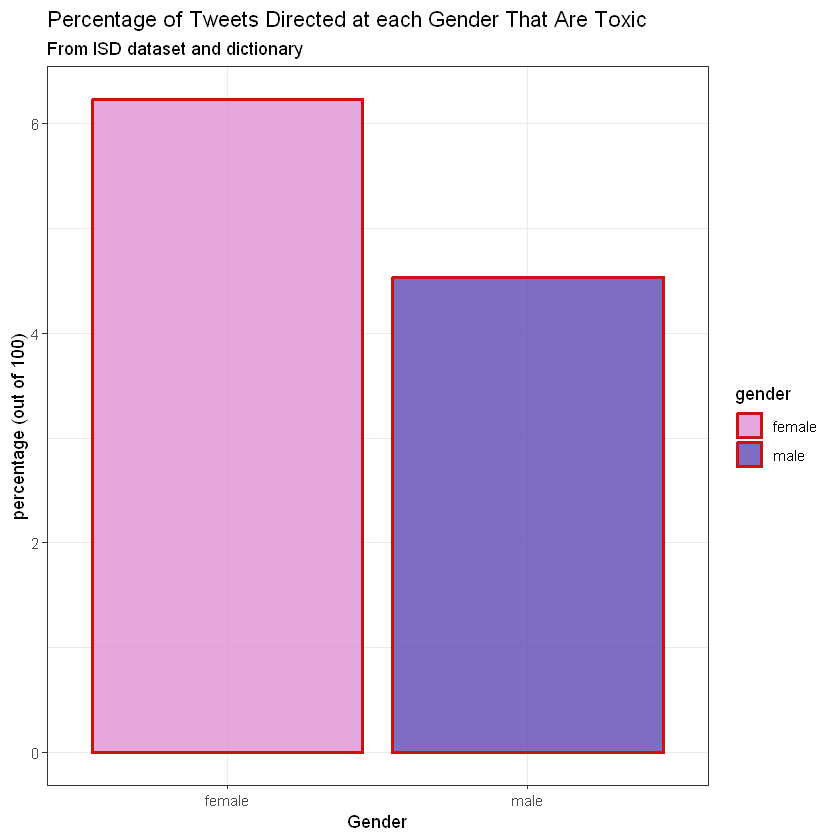

In [ ]:
gender_metrics <- data.frame(gender=c("male","female"),value=c(men_pct_neg,women_pct_neg))

gender_graph <- gender_metrics |>
ggplot(aes(x=gender,y=value, fill=gender))+ 
    geom_bar(stat="identity",color="#cc1111", linewidth=1, alpha=0.8)+
    scale_fill_manual(values=c("#e092d3", "#5e49b0"))+
    theme(axis.text.x = element_text(angle = 0, vjust=1), legend.position = "none")+
    labs(y="percentage (out of 100)", x="Gender", subtitle = "From ISD dataset and dictionary")+
    ggtitle("Percentage of Tweets Directed at each Gender That Are Toxic")+
    theme_bw()

gender_graph

ggsave("gender_bias_ISD.png")

**Category analysis**

What percentage of tweets to each category of user are toxic? Run `category_metrics` for the result.

In [ ]:
health_communicators_roles <- read_csv("Health Communicators - List(Communicators).csv")

Rows: 155 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (6): Handle, Name, Category, Category - simplified, Gender, Description

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
UBC_ISD_text <- UBC_ISD |>
select("twitter.tweet/text")|>
rename(text="twitter.tweet/text")|>
mutate_all(na_if,"")|>
drop_na()|>
distinct() #removes retweets

In [ ]:
health_communicators_roles <- health_communicators_roles |>
select(Handle, "Category - simplified")|>
rename(Category="Category - simplified")

In [ ]:
#converting everything to lists

medical_professional <- health_communicators_roles|>
filter(Category=="Medical professional")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename("medical_professional"=Handle)|>
  as.list()|>
  paste(collapse = "', '")

expert_university <- health_communicators_roles|>
filter(Category=="Expert - university")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(expert_university=Handle)|>
  as.list()|>
  paste(collapse = "', '")

politician <- health_communicators_roles |>
  filter(Category == "Politician")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(politician=Handle)|>
  as.list()|>
  paste(collapse = "', '")

journalist <- health_communicators_roles |>
  filter(Category == "Journalist")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(journalist=Handle)|>
  as.list()|>
  paste(collapse = "', '")

civil_society_groups <- health_communicators_roles |>
  filter(Category == "Civil society groups")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(civil_society_groups=Handle)|>
  as.list()|>
  paste(collapse = "', '")

expert <- health_communicators_roles |>
  filter(Category == "Expert")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(expert=Handle)|>
  as.list()|>
  paste(collapse = "', '")

health_official <- health_communicators_roles |>
  filter(Category == "Health official")|>
  mutate(Handle = str_remove(Handle, "@"))|>
  select(Handle)|>
  rename(health_official=Handle)|>
  as.list()|>
  paste(collapse = "', '")

In [ ]:
health_official <- c("CDCofBC", "ChiefSciCan", "CMOH_Alberta", "CMOH_NL", "CPHO_Canada", "epdevilla", "OttawaHealth", "roussin_brent", "StrangRobert", "VeraEtches")
expert <- c("BogochIsaac", "CaulfieldTim", "DeNovo_Fatima", "deonandan", "DFisman", "Dr_ChrisSimpson", "drgigiosler", "DrKaliBarrett", "drmwarner", "drsusanshaw", "DrVivianS", "First10EM", "GermHunterID", "goaliegirlmom31", "heysciencesam", "IDEpiPhD", "imgrund", "iPreetBrar", "IrfanDhalla", "jkwan_md", "jonathanstea", "KashPrime", "Kevin__Parent", "KindrachukJason", "KrishanaSankar", "kwadwo777", "LisaBarrettID", "MoriartyLab", "MPaiMD", "NaheedD", "NathanStall", "paimadhu", "RicharLisa", "sabivm", "SammyG_MD", "SciChefCan", "sdbaral", "SharkawyMD", "shazmamithani", "SteiniBrown", "TorontoIDDOC", "UbakaOgbogu", "zchagla")
civil_society_groups <- c("blackdocscanada", "cmcovidtf", "conquercovid19", "COVID_19_Canada", "COVIDSciOntario", "McGillOSS", "sacovidtf", "ScienceUpFirst", "thisisourshotca", "VaxHuntersCan")
journalist <- c("asapscience", "binhanv", "carlyweeks", "ctouzin", "CTV_AvisFavaro", "egpayne", "j_mcelroy", "jasonfherring", "jfrketich", "JWongGlobalNews", "jyangstar", "LaurenPelley", "NightShiftMD", "NoLore", "picardonhealth", "sharon_kirkey", "theresaboyle", "VikCBC")
politician <- c("adriandix", "cdube_sante", "celliottability", "ErnieHudsonPEI", "everetthindley", "Johnrockdoc", "juliegreenMLA", "MerrimanPaul", "MLAStefanson", "PattyHajdu", "shandro", "ShephardDorothy", "zachchurchill")
expert_university <- c("AmyGreerKalisz", "angie_rasmussen", "AnnaBlakney", "AntibioticDoc", "ASPphysician")
medical_professional<- c("AlikaMD")

In [ ]:


# Filter the dataset for entries containing any of the health officials
health_official_df <- UBC_ISD_text %>%
  filter(grepl(paste(health_official, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_health_official <- nrow(health_official_df)
negative_entries_health_official <- nrow(health_official_df |> filter(negative == 1))
health_official_pct_neg <- negative_entries_health_official / total_entries_health_official * 100

expert_df <- UBC_ISD_text|>
  filter(grepl(paste(expert, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_expert <- nrow(expert_df)    
negative_entries_expert <- nrow(expert_df |> filter(negative == 1))
expert_pct_neg <- negative_entries_expert/total_entries_expert*100

civil_society_groups_df <- UBC_ISD_text|>
  filter(grepl(paste(civil_society_groups, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_civil_society_groups <- nrow(civil_society_groups_df)    
negative_entries_civil_society_groups <- nrow(civil_society_groups_df |> filter(negative == 1))
civil_society_groups_pct_neg <- negative_entries_civil_society_groups/total_entries_civil_society_groups*100

journalist_df <- UBC_ISD_text|>
  filter(grepl(paste(journalist, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_journalist <- nrow(journalist_df)    
negative_entries_journalist <- nrow(journalist_df |> filter(negative == 1))
journalist_pct_neg <- negative_entries_journalist/total_entries_journalist*100

politician_df <- UBC_ISD_text|>
  filter(grepl(paste(women, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_politician <- nrow(politician_df)    
negative_entries_politician <- nrow(politician_df |> filter(negative == 1))
politician_pct_neg <- negative_entries_politician/total_entries_politician*100

expert_university_df <- UBC_ISD_text|>
  filter(grepl(paste(expert_university, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_expert_university <- nrow(expert_university_df)    
negative_entries_expert_university <- nrow(expert_university_df |> filter(negative == 1))
expert_university_pct_neg <- negative_entries_expert_university/total_entries_expert_university*100

medical_professional_df <- UBC_ISD_text|>
  filter(grepl(paste(medical_professional, collapse = "|"), text, ignore.case = TRUE))|>
  mutate(negative = as.integer(grepl(pattern, text, ignore.case = TRUE)))
total_entries_medical_professional<- nrow(medical_professional_df)    
negative_entries_medical_professional <- nrow(medical_professional_df |> filter(negative == 1))
medical_professional_pct_neg <- negative_entries_medical_professional/total_entries_medical_professional*100


In [ ]:
category_metrics <- data.frame(category=c("health_official", "expert", "civil_society_groups", "journalist", "politician", "expert_university","medical_professional"),
                                value=c(health_official_pct_neg, expert_pct_neg, civil_society_groups_pct_neg, journalist_pct_neg, politician_pct_neg,expert_university_pct_neg,medical_professional_pct_neg))

write.csv(category_metrics, "category_metrics_ISD")


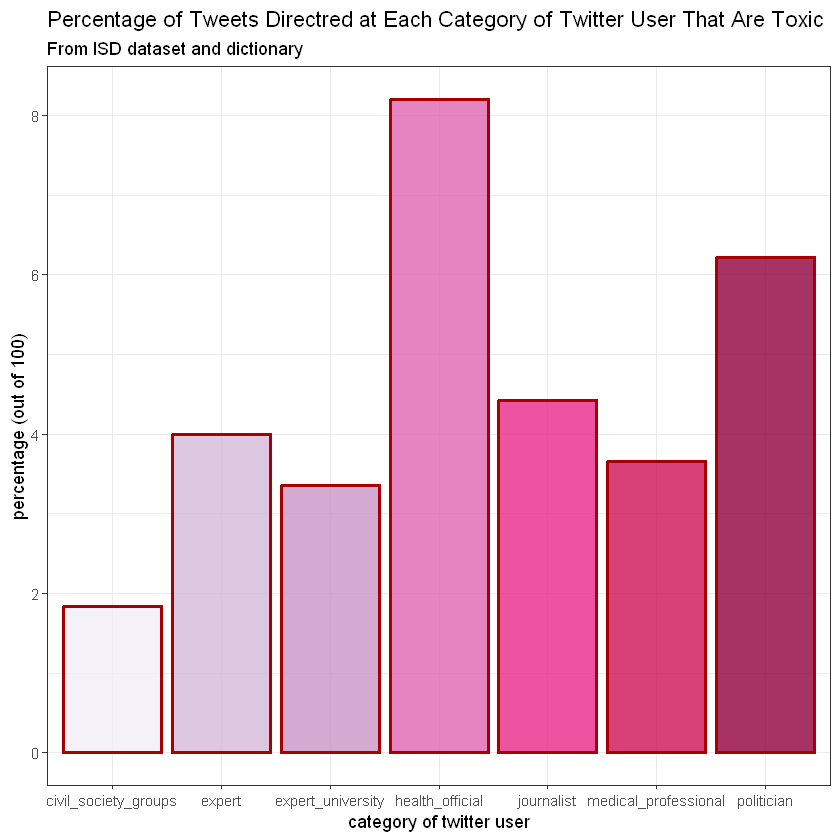

In [ ]:
library(RColorBrewer)
category_graph <- category_metrics|>
ggplot(aes(x=category,y=value, fill=category))+ 
    geom_bar(stat="identity",color="#a60000", linewidth=1, alpha=0.8)+
    scale_fill_brewer(palette = "PuRd")+
    theme(axis.text.x = element_text(angle = 0, vjust=1), legend.position = "none")+
    labs(y="percentage (out of 100)", x="category of twitter user", subtitle = "From ISD dataset and dictionary")+
    ggtitle("Percentage of Tweets Directred at Each Category of Twitter User That Are Toxic")+
    theme_bw()+
    theme(legend.position="none")
category_graph

ggsave("category_hate_terms_ISD.png", width=10, height=5)